In [1]:
# import required libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
import re
import nltk

In [23]:
# Load data from CSV file
data = pd.read_csv('tweets.csv', header=0)
# data1 = pd.read_csv('tweets.csv', header=0)

higher_quality_data = data[(data['qScore'] >=  0.571552) & (data['nScore'] >= 0)] # further cleaning data according to qscore and nscore 25 percentile values

# print (data.describe())
# Average qscore = 0.596829209
# Average nscore = 0.605678059


lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = list(STOPWORDS)
stop_words.append("amp")

def preprocess_tweet_new(tweet):
    # convert to lowercase
    tweet = tweet.lower()
    # remove links
    tweet = re.sub(r'http\S+', '', tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # remove punctuation
    tweet = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(tweet)
    # remove stop words
    tweet = [w for w in tweet if not w in stop_words and len(w) > 2]
    # lemmatize words eg. running -> run
    tweet = [lemmatizer.lemmatize(w) for w in tweet]
    return tweet

processed_data = data['text'].map(preprocess_tweet_new)

higher_quality_processed_data = higher_quality_data['text'].map(preprocess_tweet_new)

In [24]:
# Create a dictionary of words
dictionary = corpora.Dictionary(processed_data)
# Create a dictionary of words for tweets with higher qscore and nscore
higher_quality_dictionary = corpora.Dictionary(higher_quality_processed_data)

In [25]:
# Create a corpus
corpus = [dictionary.doc2bow(tweet) for tweet in processed_data]
# Create a corpus for tweets of higher q and n score
higher_quality_corpus = [higher_quality_dictionary.doc2bow(tweet) for tweet in higher_quality_processed_data]

In [26]:
# Define number of topics
num_topics = 9

In [27]:
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=num_topics,
                                   random_state=100,
#                                    update_every=1,
#                                    chunksize=70,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)




In [28]:
for i, topic in lda_model.print_topics():
    print(f'Topic: {i} \nWords: {topic}\n')

Topic: 0 
Words: 0.013*"london" + 0.009*"scotland" + 0.008*"link" + 0.007*"look" + 0.006*"day" + 0.006*"like" + 0.006*"good" + 0.006*"going" + 0.006*"best" + 0.005*"know"

Topic: 1 
Words: 0.012*"time" + 0.011*"london" + 0.010*"year" + 0.009*"ticket" + 0.006*"manchester" + 0.006*"england" + 0.006*"day" + 0.006*"game" + 0.005*"week" + 0.005*"night"

Topic: 2 
Words: 0.010*"like" + 0.008*"come" + 0.007*"world" + 0.006*"worker" + 0.006*"people" + 0.005*"let" + 0.005*"real" + 0.005*"labour" + 0.005*"racing" + 0.004*"want"

Topic: 3 
Words: 0.019*"labour" + 0.015*"tory" + 0.014*"people" + 0.011*"party" + 0.011*"conservative" + 0.010*"boris" + 0.009*"right" + 0.008*"government" + 0.008*"think" + 0.007*"vote"

Topic: 4 
Words: 0.108*"york" + 0.105*"stuart" + 0.105*"armstrong" + 0.105*"sophia" + 0.105*"symons" + 0.105*"athena" + 0.105*"spender" + 0.105*"jared" + 0.001*"tom" + 0.001*"spot"

Topic: 5 
Words: 0.010*"born" + 0.009*"set" + 0.008*"living" + 0.007*"men" + 0.006*"hell" + 0.006*"link" 

In [29]:
coherence_model_lda = CoherenceModel(
        model=lda_model, texts=processed_data, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(corpus)
perplexity = 2**(-perplexity)

print('\nCoherence Score: ', coherence_lda)
print('\nPerplexity Score: ', perplexity)


Coherence Score:  -8.940292325416314

Perplexity Score:  709.7193377750007


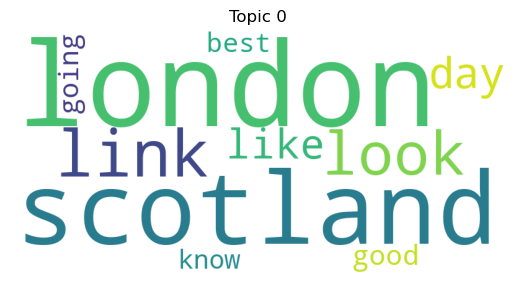

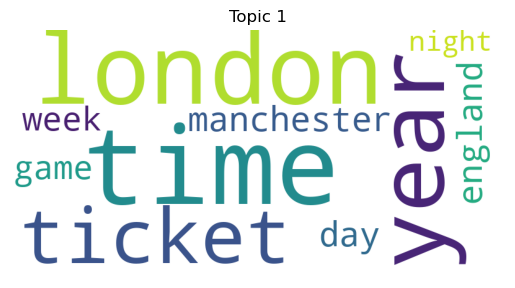

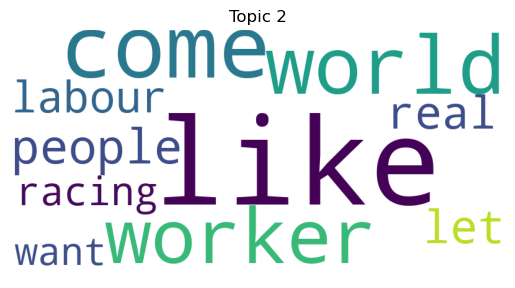

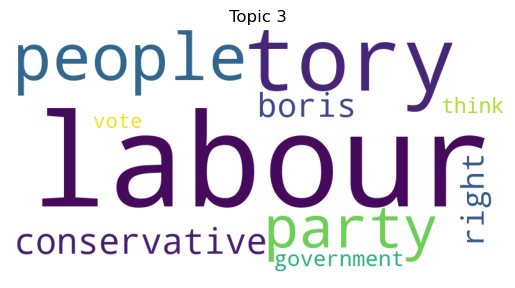

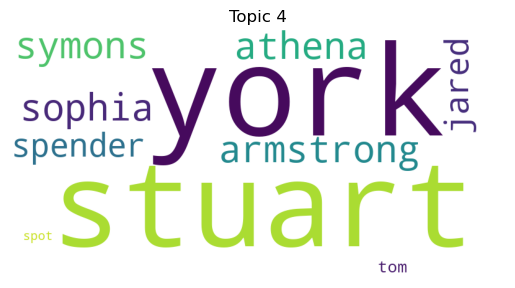

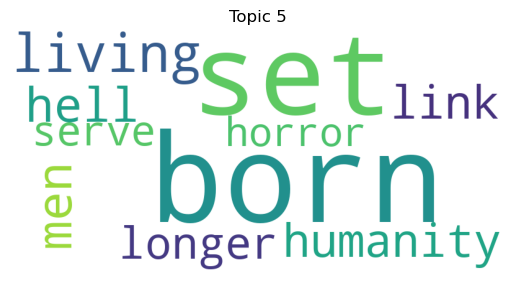

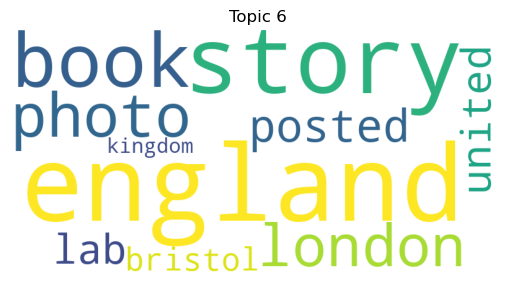

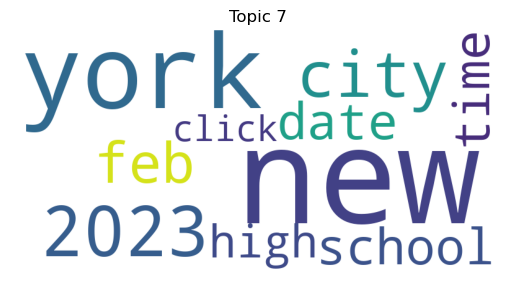

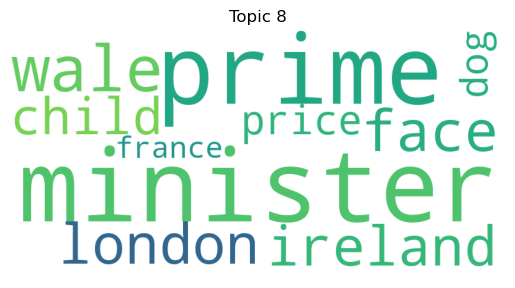

In [30]:
def visualize_topics(lda_model):
    topics = lda_model.show_topics(num_topics=-1, formatted=False)
    for i, topic in topics:
        words = dict(topic)
        plt.figure()
        plt.imshow(WordCloud(width=800, height=400, background_color='white').fit_words(words))
        plt.axis('off')
        plt.title('Topic ' + str(i))
        plt.show()
visualize_topics(lda_model)

# displaying topics from all tweets

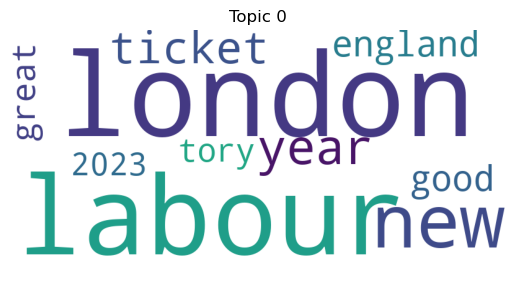

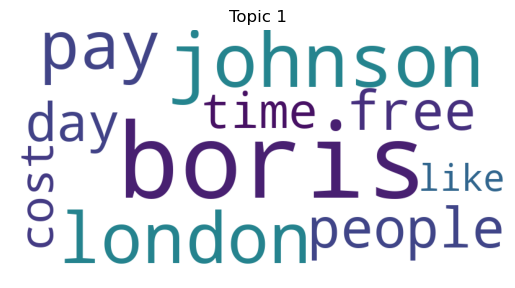

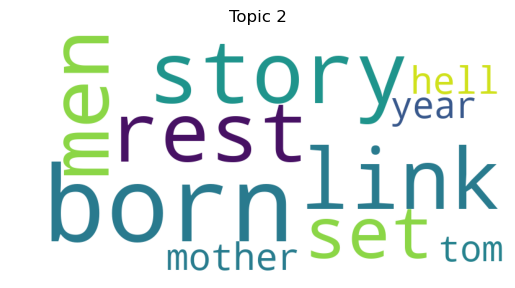

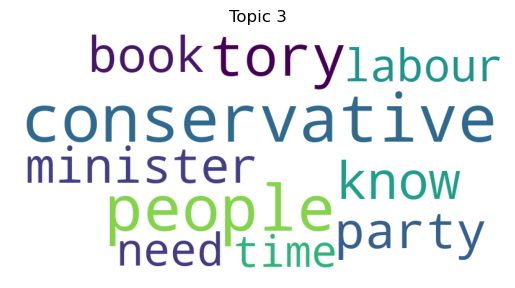

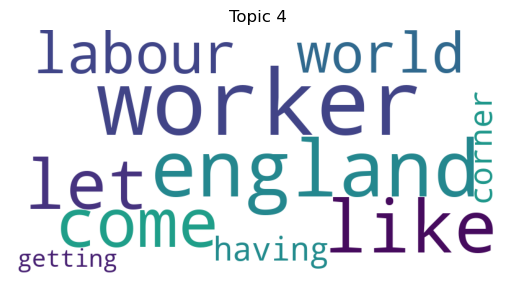

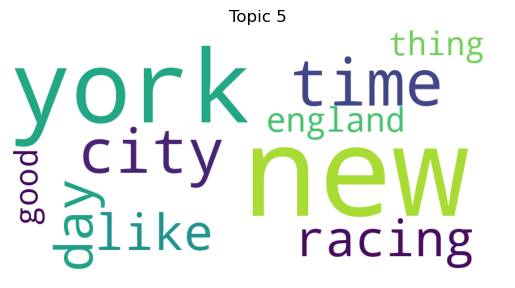

In [46]:
# displaying topics from corpus of higher n and q score
higher_quality_lda_model = gensim.models.LdaModel(corpus=higher_quality_corpus,
                                   id2word=higher_quality_dictionary,
                                   num_topics=6,
                                   random_state=100,
                                   passes=20,
                                   alpha='auto',
                                   per_word_topics=True)
visualize_topics(higher_quality_lda_model)

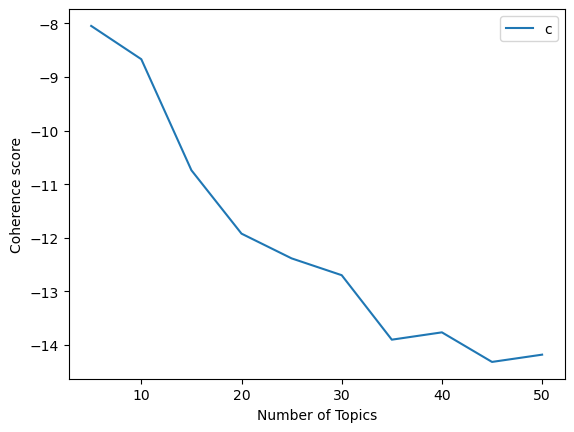

In [32]:

coherence_values = []
num_topics_list = list(range(5, 51, 5))

for num_topics in num_topics_list:
    lda_model_graph = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       alpha='auto')
    
    coherence_model_lda = CoherenceModel(model=lda_model_graph, texts=processed_data, dictionary=dictionary, coherence='u_mass')
    coherence = coherence_model_lda.get_coherence()
    coherence_values.append(coherence)

# Plotting graph

plt.plot(num_topics_list, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [33]:
num_items = len(data)

# Get the length statistics
length_stats = data['text'].apply(len).describe()

# Print the statistics
print("Number of items:", num_items)
print("Length statistics:\n", length_stats)


Number of items: 10001
Length statistics:
 count    10001.00000
mean       151.90081
std         83.49657
min         18.00000
25%         84.00000
50%        132.00000
75%        215.00000
max        926.00000
Name: text, dtype: float64


Number of tweets: 10001
Minimum length: 18
Maximum length: 926
Average length: 151.9008099190081


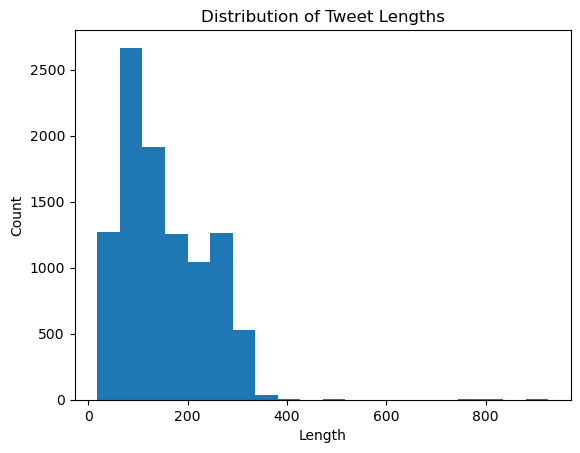

234389
Minimum length in words: 4
Maximum length in words: 100
Average length in words: 23.436556344365563


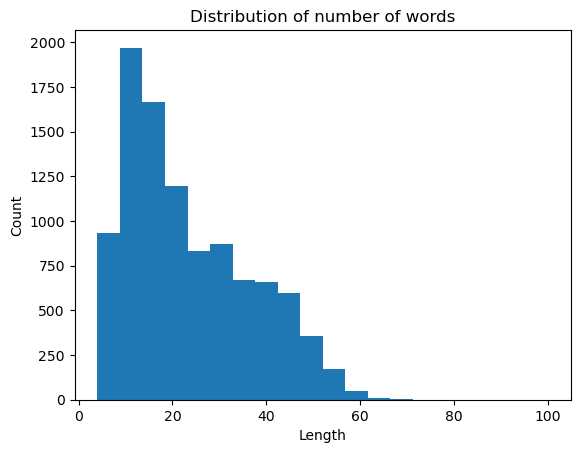

In [47]:
data['length'] = data['text'].apply(len)
data['num_words'] = data['text'].apply(lambda x: len(x.split()))

# calculate statistics
num_tweets = len(data)
min_len = data['length'].min()
max_len = data['length'].max()
avg_len = data['length'].mean()

min_words = data['num_words'].min()
max_words = data['num_words'].max()
avg_len_words = data['num_words'].mean()


# print statistics
print("Number of tweets:", num_tweets)
print("Minimum length:", min_len)
print("Maximum length:", max_len)
print("Average length:", avg_len)

# plot histogram of tweet lengths
plt.hist(data['length'], bins=20)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

# print statistics
print(data['num_words'].sum())
print("Minimum length in words:", min_words)
print("Maximum length in words:", max_words)
print("Average length in words:", avg_len_words)

# plot histogram of tweet words
plt.hist(data['num_words'], bins=20)
plt.title('Distribution of number of words')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

In [52]:
# Working with grouped tweets
df = pd.read_csv('groupedTweets.csv')
# Average qscore = 0.596870203
# Average nscore = 0.608089162

higher_quality_grouped_data = df[(df['qScore'] >= 0.6) & (df['nScore'] >= 0.6)]
# group tweets according to group ID
grouped_tweets = df.groupby('group')['text'].apply(lambda x: ''.join(x))
higher_quality_grouped_tweets = higher_quality_grouped_data.groupby('group')['text'].apply(lambda x: ''.join(x))
# print(grouped_tweets[0])
preprocessed_tweets = grouped_tweets.apply(preprocess_tweet_new)
hq_preprocessed_tweets = higher_quality_grouped_tweets.apply(preprocess_tweet_new)
# print(preprocessed_tweets[0])

# create dictionary and corpus
dictionary = corpora.Dictionary(preprocessed_tweets)
corpus = [dictionary.doc2bow(tweet) for tweet in preprocessed_tweets]
hq_dictionary = corpora.Dictionary(hq_preprocessed_tweets)
hq_corpus = [hq_dictionary.doc2bow(tweet) for tweet in hq_preprocessed_tweets]

# run LDA model
lda_model_grouped = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=8,
                                   passes=50,
                                   alpha='auto')

# print topics and their corresponding words
for idx, topic in lda_model_grouped.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')


Topic: 0 
Words: 0.009*"people" + 0.004*"new" + 0.004*"time" + 0.003*"like" + 0.003*"great" + 0.003*"year" + 0.003*"london" + 0.003*"tory" + 0.003*"york" + 0.002*"conservative"

Topic: 1 
Words: 0.008*"labour" + 0.006*"london" + 0.006*"new" + 0.006*"people" + 0.005*"york" + 0.004*"like" + 0.004*"love" + 0.003*"time" + 0.003*"good" + 0.003*"need"

Topic: 2 
Words: 0.011*"like" + 0.010*"new" + 0.006*"york" + 0.004*"city" + 0.004*"england" + 0.004*"labour" + 0.004*"london" + 0.004*"know" + 0.003*"2023" + 0.003*"year"

Topic: 3 
Words: 0.010*"london" + 0.005*"england" + 0.004*"need" + 0.004*"boris" + 0.004*"like" + 0.004*"day" + 0.003*"people" + 0.003*"year" + 0.003*"york" + 0.003*"sunak"

Topic: 4 
Words: 0.011*"new" + 0.009*"york" + 0.006*"london" + 0.006*"time" + 0.004*"like" + 0.003*"year" + 0.003*"right" + 0.003*"people" + 0.003*"city" + 0.002*"think"

Topic: 5 
Words: 0.019*"new" + 0.011*"york" + 0.006*"time" + 0.006*"london" + 0.004*"2023" + 0.003*"people" + 0.003*"year" + 0.003*"da

In [53]:
coherence_model_lda = CoherenceModel(
        model=lda_model_grouped, texts=preprocessed_tweets, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()

perplexity = lda_model_grouped.log_perplexity(corpus)
perplexity = 2**(-perplexity)

print('\nCoherence Score: ', coherence_lda)
print('\nPerplexity Score: ', perplexity)



Coherence Score:  -0.7594261773528105

Perplexity Score:  743.3732116562242


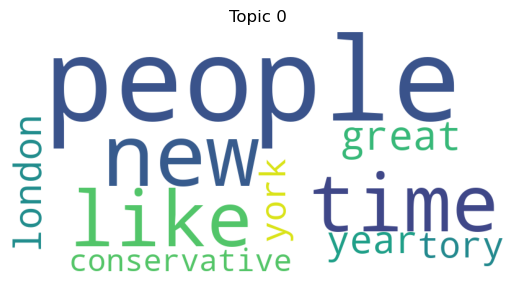

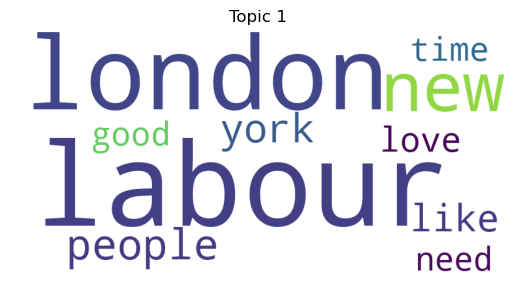

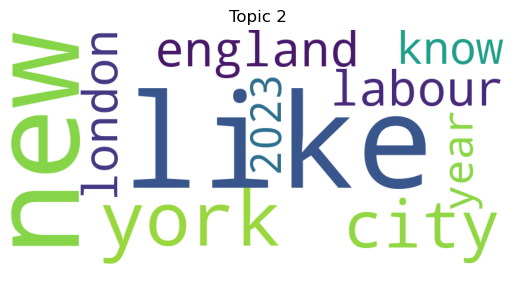

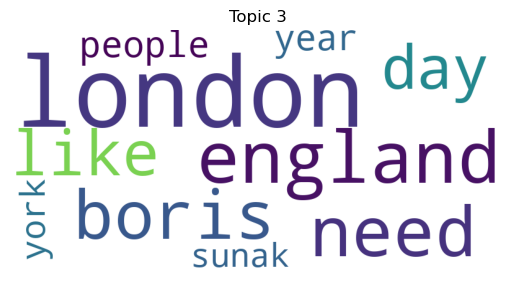

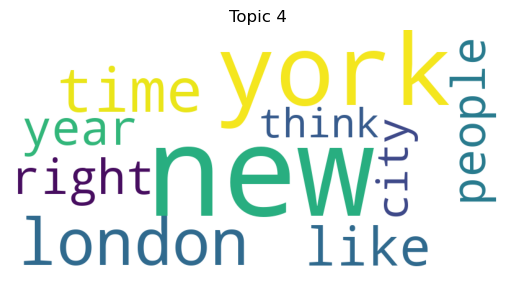

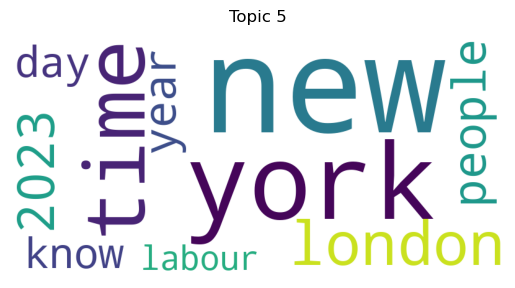

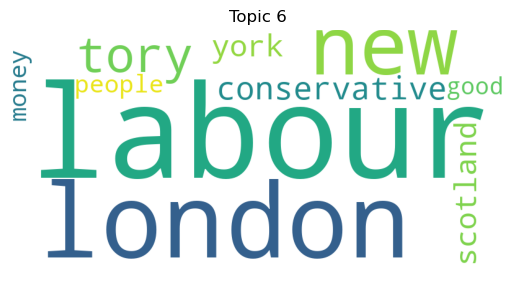

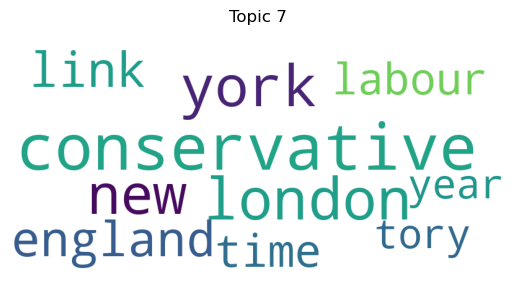

In [54]:
visualize_topics(lda_model_grouped)

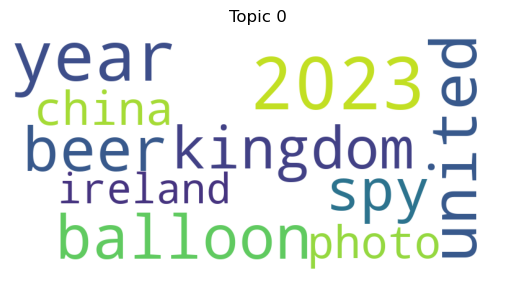

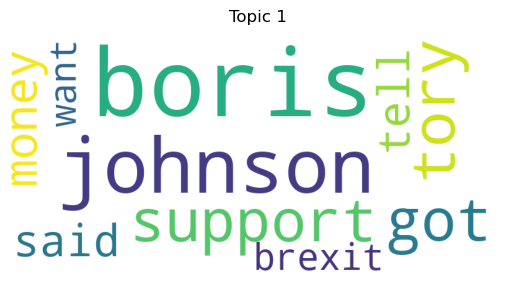

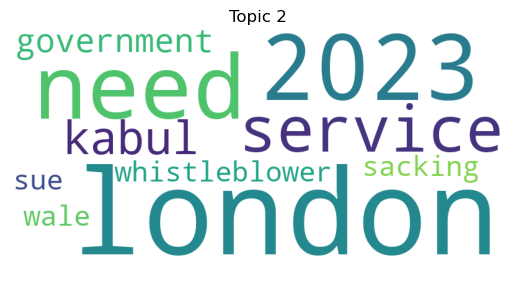

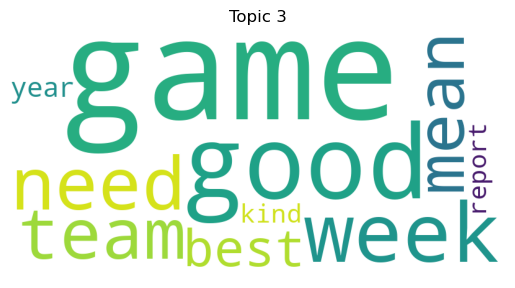

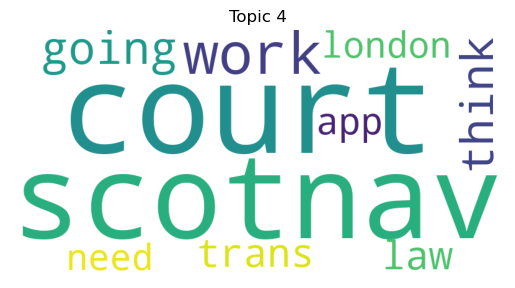

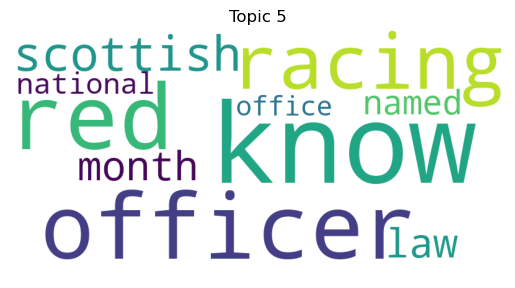

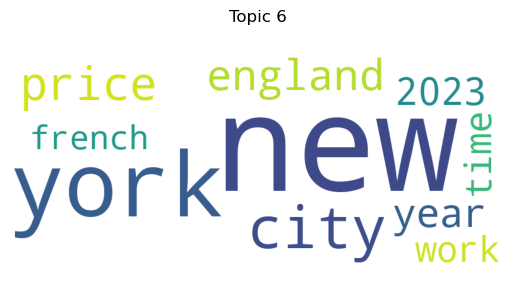

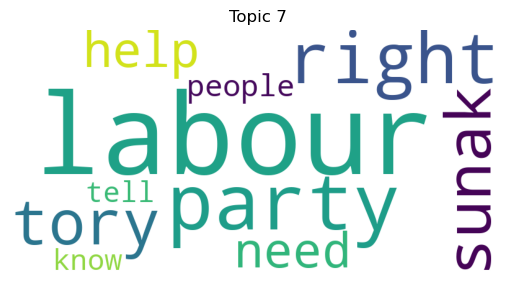

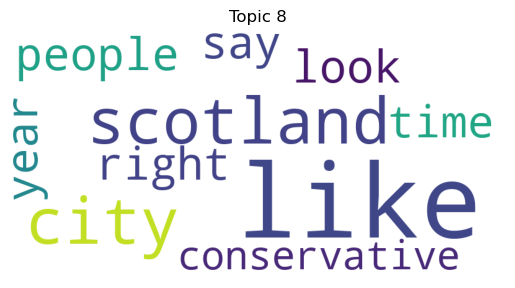

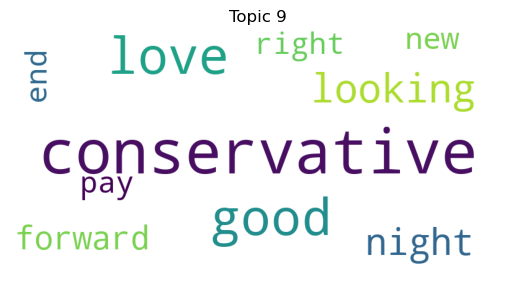

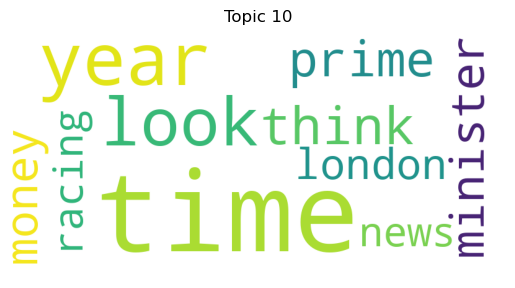

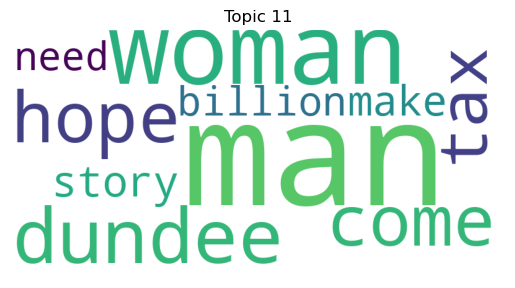

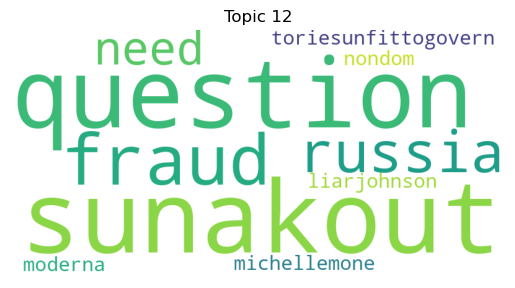

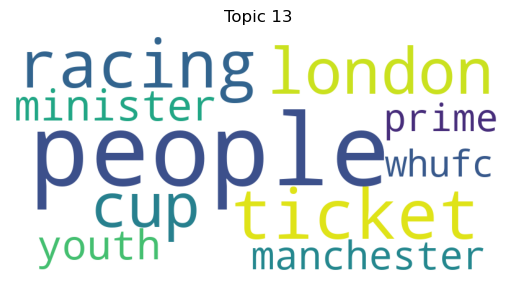

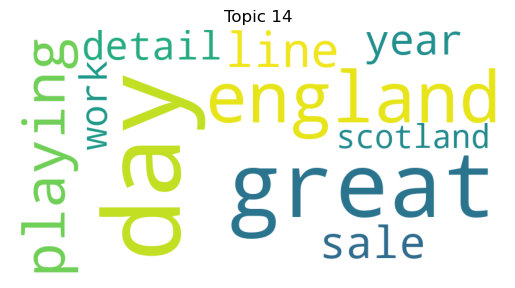

In [64]:
hq_lda_model_grouped = gensim.models.LdaModel(corpus=hq_corpus,
                                   id2word=hq_dictionary,
                                   num_topics=15,
                                   passes=50,
                                   alpha='auto')
visualize_topics(hq_lda_model_grouped)

Total number of groups: 471
Maximum number of words in a group: 22040
Minimum number of words in a group: 4
Mean number of words per group: 475.9490445859873
Median number of words per group: 80.0
Minimum length in characters: 31.0
Maximum length in characters: 151671.0
Average length in characters: 3215.4012738853503


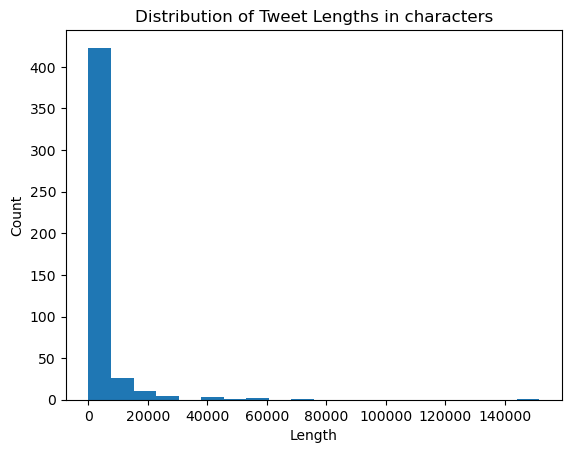

Minimum length in words: 4.0
Maximum length in words: 22040.0
Average length in words: 475.9490445859873


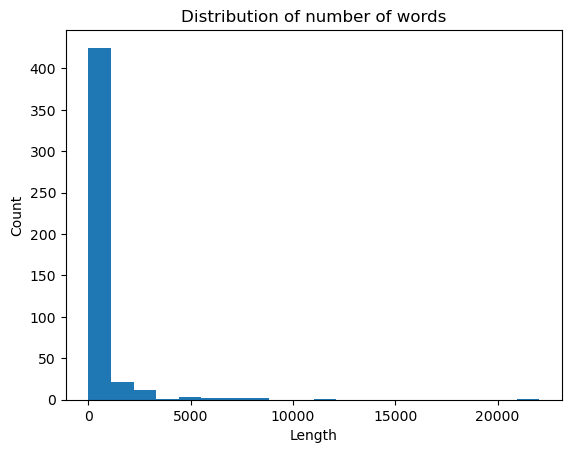

In [39]:

tweet_lengths = grouped_tweets.apply(lambda x: len(x.split()))
print(f'Total number of groups: {len(tweet_lengths)}')
print(f'Maximum number of words in a group: {tweet_lengths.max()}')
print(f'Minimum number of words in a group: {tweet_lengths.min()}')
print(f'Mean number of words per group: {tweet_lengths.mean()}')
print(f'Median number of words per group: {tweet_lengths.median()}')


df['length'] = grouped_tweets.apply(len)
df['num_words'] = grouped_tweets.apply(lambda x: len(x.split()))
# calculate statistics
# num_tweets = len(grouped_tweets)
min_len = df['length'].min()
max_len = df['length'].max()
avg_len = df['length'].mean()

min_words = df['num_words'].min()
max_words = df['num_words'].max()
avg_len_words = df['num_words'].mean()


# print statistics
# print("Number of tweets:", num_tweets)
print("Minimum length in characters:", min_len)
print("Maximum length in characters:", max_len)
print("Average length in characters:", avg_len)

# plot histogram of tweet lengths
plt.hist(df['length'], bins=20)
plt.title('Distribution of Tweet Lengths in characters')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

# print statistics
print("Minimum length in words:", min_words)
print("Maximum length in words:", max_words)
print("Average length in words:", avg_len_words)

# plot histogram of tweet words
plt.hist(df['num_words'], bins=20)
plt.title('Distribution of number of words')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

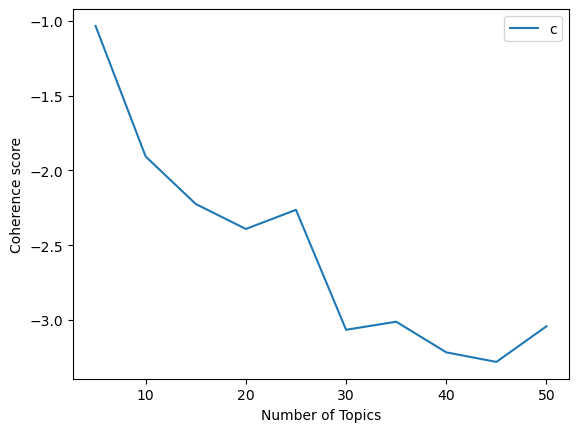

In [40]:
# Get graph of coherence vs num of topics

coherence_values = []
num_topics_list = list(range(5, 51, 5))

for num_topics in num_topics_list:
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       passes=10,
                                       alpha='auto')
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_tweets, dictionary=dictionary, coherence='u_mass')
    coherence = coherence_model_lda.get_coherence()
    coherence_values.append(coherence)


plt.plot(num_topics_list, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()